In [2]:
 #%matplotlib inline
import numpy as np
import pickle
import os
#from matplotlib import pyplot as plt
from keras.layers import Input, Dense, Lambda
from keras.models import Model
from keras import objectives
from keras import backend as K
from keras.callbacks import ReduceLROnPlateau, ModelCheckpoint, Callback
from IPython.display import clear_output
import matplotlib.pyplot as plt
import pandas as pd

Using TensorFlow backend.


In [0]:
class PlotLosses(Callback):
    def on_train_begin(self, logs={}):
        self.i = 0
        self.x = []
        self.losses = []
        self.val_losses = []
        
        self.fig = plt.figure()
        
        self.logs = []

    def on_epoch_end(self, epoch, logs={}):
        
        self.logs.append(logs)
        self.x.append(self.i)
        self.losses.append(logs.get('loss'))
        self.val_losses.append(logs.get('val_loss'))
        self.i += 1
        
        clear_output(wait=True)
        plt.plot(self.x, self.losses, label="loss")
        plt.plot(self.x, self.val_losses, label="val_loss")
        plt.legend()
        plt.show();
        
plot_losses = PlotLosses()

In [0]:
# encoder/decoder network size
batch_size=50
original_dim=9929 # number of location
intermediate_dim=200
latent_dim=100
nb_epochs=200
epsilon_std=2.0

In [6]:
6470 / 50

129.4

In [0]:
# encoder network
x=Input(batch_shape=(batch_size,original_dim))
h=Dense(intermediate_dim, activation='relu')(x)
z_mean=Dense(latent_dim)(h)
z_log_var=Dense(latent_dim)(h)

In [0]:
def sampling(args):
    _mean,_log_var=args
    epsilon=K.random_normal(shape=(K.shape(z_mean)[0], latent_dim), mean=0., stddev=epsilon_std)
    return _mean+K.exp(_log_var/2)*epsilon

z= Lambda(sampling, output_shape=(latent_dim,))([z_mean, z_log_var])

In [0]:
# decoder network
h_decoder=Dense(intermediate_dim, activation='relu')
x_bar=Dense(original_dim,activation='softmax') # this should be softmax right?
h_decoded = h_decoder(z)
x_decoded = x_bar(h_decoded)

In [0]:
# build and compile model
vae = Model(x, x_decoded)
def vae_loss(x,x_bar):
    reconst_loss=original_dim*objectives.binary_crossentropy(x, x_bar)
    kl_loss=-0.5*K.sum(1 + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis=-1)
    return reconst_loss + kl_loss

vae.compile(optimizer='adam', loss=vae_loss)

In [11]:
vae.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (50, 9929)           0                                            
__________________________________________________________________________________________________
dense_1 (Dense)                 (50, 200)            1986000     input_1[0][0]                    
__________________________________________________________________________________________________
dense_2 (Dense)                 (50, 100)            20100       dense_1[0][0]                    
__________________________________________________________________________________________________
dense_3 (Dense)                 (50, 100)            20100       dense_1[0][0]                    
____________________________________________________________________________________________

In [0]:
DATA_DIR = os.path.join("..","..","data")

In [13]:
x_train = pickle.load( open( os.path.join(DATA_DIR, "train_data.file"), "rb" ) )
#x_train = x_train[0:118000, :]
print("number of training users: ", x_train.shape)

x_val = pickle.load( open( os.path.join(DATA_DIR,"val_data.file"), "rb" ) )
x_val = x_val.todense()
print("number of validation users: ", x_val.shape)

x_test = pickle.load( open( os.path.join(DATA_DIR, "test_data.file"),'rb') )
x_test = x_test.todense()
print("number of test users : ", x_test.shape)

number of training users:  (7613, 9929)
number of validation users:  (1142, 9929)
number of test users :  (1142, 9929)


In [14]:
x_train

<7613x9929 sparse matrix of type '<class 'numpy.float64'>'
	with 28907 stored elements in Compressed Sparse Row format>

In [0]:
def nn_batch_generator(x, y, batch_size, samples_per_epoch):
    number_of_batches = samples_per_epoch/batch_size
    counter=0
    shuffle_index = np.arange(np.shape(y)[0])
    #print(shuffle_index)
    np.random.shuffle(shuffle_index)
    x =  x[shuffle_index, :]
    y =  y[shuffle_index, :]
    while 1:
        index_batch = shuffle_index[batch_size*counter:batch_size*(counter+1)]
        #print(len(index_batch))
        x_batch = x[index_batch,:].todense()
        y_batch = y[index_batch,:].todense()
        counter += 1
        #print('x:', x_batch.shape)
        #print('y:',y_batch.shape)
        yield (np.array(x_batch),np.array(y_batch))
        if (counter >= number_of_batches):
            counter=0

In [0]:
weightsPath = os.path.join(DATA_DIR, "tmp/weights.hdf5")
checkpointer = ModelCheckpoint(filepath=weightsPath, verbose=-1, save_best_only=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.001)

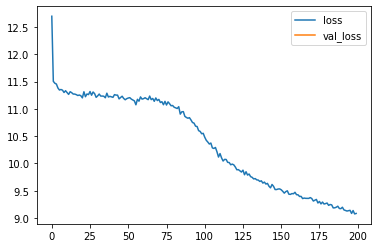

In [17]:
# shape 문제 해결하기 위해서 131로 맞춘다. 5240/40 = 총크기/배치사이즈보다 작게
vae.fit_generator(nn_batch_generator(x_train, x_train, batch_size, 120), samples_per_epoch=120, nb_epoch=nb_epochs, callbacks=[checkpointer, reduce_lr, plot_losses],)

In [18]:
x_train.shape

(7613, 9929)

In [19]:
x_train[:7600]

<7600x9929 sparse matrix of type '<class 'numpy.float64'>'
	with 28862 stored elements in Compressed Sparse Row format>

In [20]:
vae.predict(x_train[:7600], batch_size=batch_size)

array([[5.3488563e-12, 1.7547414e-05, 5.1540308e-12, ..., 3.7396488e-12,
        4.7307054e-12, 6.3586150e-12],
       [2.6980229e-10, 2.9240246e-04, 2.9629896e-10, ..., 2.4977156e-10,
        2.8205341e-10, 3.6965347e-10],
       [1.0743889e-30, 3.1723154e-03, 1.7020660e-30, ..., 7.9213216e-31,
        6.8706742e-31, 8.4357424e-31],
       ...,
       [6.1118255e-16, 9.9502477e-06, 7.3953944e-16, ..., 5.8349267e-16,
        5.7113833e-16, 8.6971342e-16],
       [6.9955930e-11, 9.2063849e-05, 8.5167498e-11, ..., 7.4682767e-11,
        5.5555869e-11, 6.3837172e-11],
       [2.4051952e-13, 2.5147025e-03, 2.8714360e-13, ..., 2.8879576e-13,
        3.0195307e-13, 2.8180464e-13]], dtype=float32)

In [0]:
vae.save(os.path.join(DATA_DIR, 'model.hdf5'))

In [0]:
vae.save_weights(os.path.join(DATA_DIR, 'model_weights.hdf5'))

In [0]:
prediction = vae.predict(x_train[:7600], batch_size=batch_size)

In [0]:
저장하기
 with open('prediction_matrix.pkl', 'wb') as f:
  pickle.dump(prediction, f)

## SAR (여기서부터 다시 시작)

In [0]:
import itertools
import logging
import os

import papermill as pm

from reco_utils.dataset.python_splitters import python_stratified_split, python_random_split, python_chrono_split
from reco_utils.evaluation.python_evaluation import map_at_k, ndcg_at_k, precision_at_k, recall_at_k
from reco_utils.recommender.sar.sar_singlenode import SARSingleNode

In [0]:
import datetime
import time

In [0]:
with open('prediction_matrix.pkl', 'rb') as f:
  prediction = pickle.load(f)

In [0]:
cf_data = pd.read_csv("modified_data.csv")
cf_data = cf_data

In [8]:
cf_data.shape

(37197, 4)

In [0]:
unique_user = cf_data.userId.unique()[:7600]
unique_location = cf_data.locationId.unique()[:9929]

In [0]:
input_data = pd.DataFrame(prediction)
input_data.index = unique_user
input_data.columns = unique_location

In [11]:
input_data = pd.DataFrame(input_data.stack().reset_index())
input_data.columns = ['userId', 'locationId', 'rating']
input_data

,userId,locationId,rating
0,F9AD0C1F6409A1574AD0AFC237D2A4CE,Hotel Gracery Seoul,5.753986e-13
1,F9AD0C1F6409A1574AD0AFC237D2A4CE,Hongik University Street,1.437255e-06
2,F9AD0C1F6409A1574AD0AFC237D2A4CE,Noonaholdak Hongdae,5.363232e-13
3,F9AD0C1F6409A1574AD0AFC237D2A4CE,L7 Hongdae,4.388336e-13
4,F9AD0C1F6409A1574AD0AFC237D2A4CE,Myeongdong Shopping Street,9.679204e-12
...,...,...,...
75460395,F6FCC0E18883E4DFEAE6C8A577DABD13,Itaewon Land,2.579776e-25
75460396,F6FCC0E18883E4DFEAE6C8A577DABD13,Hostel 88 Seoul Crown,2.848969e-25
75460397,F6FCC0E18883E4DFEAE6C8A577DABD13,Star Hostel Myeongdong Family,3.287108e-25
75460398,F6FCC0E18883E4DFEAE6C8A577DABD13,International Convention Center Jeju,1.810562e-25


#### 이 부분 수정해야함
: 기존의 방식과 달리 timestamp를 어떻게 채워넣어야할지 고려해야한다.

In [0]:
cf_data.timestamp = cf_data.timestamp.apply(lambda x: time.mktime(datetime.datetime.strptime(x, '%Y-%m-%d').timetuple()))

In [0]:
id2time = {}
for id, time in zip(cf_data.userId, cf_data.timestamp):
  id2time[id] = time

In [0]:
input_data['timestamp'] = input_data.userId.map(id2time)

In [15]:
input_data.loc[input_data.timestamp.isnull()]

,userId,locationId,rating,timestamp


In [16]:
!pip install git+https://github.com/microsoft/recommenders

  Cloning https://github.com/microsoft/recommenders to /tmp/pip-req-build-ew3hnwdn
  Running command git clone -q https://github.com/microsoft/recommenders /tmp/pip-req-build-ew3hnwdn
  Created wheel for reco-utils: filename=reco_utils-2019.9-cp36-none-any.whl size=164194 sha256=175d1250369747b8d6e7a73e0ecfd9914dfb6717f7668beaad20fba2489d0b51
  Stored in directory: /tmp/pip-ephem-wheel-cache-vjosbg73/wheels/b4/1c/70/c3f6005781b2b5a3370ec55bdd75c10ed1b07456bdfb1a0524
Successfully built reco-utils


In [17]:
input_data.groupby('locationId').agg({'userId': "count"}).describe()

,userId
count,9929.0
mean,7600.0
std,0.0
min,7600.0
25%,7600.0
50%,7600.0
75%,7600.0
max,7600.0


### data preprocessing & modeling

In [0]:
df=input_data
df.columns = ['id','location.locationId',	'rating',	'createdDate']

In [19]:
df.head()

,id,location.locationId,rating,createdDate
0,F9AD0C1F6409A1574AD0AFC237D2A4CE,Hotel Gracery Seoul,5.753986e-13,1.583021e+09
1,F9AD0C1F6409A1574AD0AFC237D2A4CE,Hongik University Street,1.437255e-06,1.583021e+09
2,F9AD0C1F6409A1574AD0AFC237D2A4CE,Noonaholdak Hongdae,5.363232e-13,1.583021e+09
3,F9AD0C1F6409A1574AD0AFC237D2A4CE,L7 Hongdae,4.388336e-13,1.583021e+09
4,F9AD0C1F6409A1574AD0AFC237D2A4CE,Myeongdong Shopping Street,9.679204e-12,1.583021e+09


In [0]:
# RAM을 모두 사용하기 때문에 평점으로 필터링 해보자.
df = df.loc[df.rating>=0.001]

In [0]:
# top k items to recommend
TOP_K = 10
DATA_SIZE = df.shape[0]

In [0]:
DEFAULT_USER_COL= 'id',
DEFAULT_ITEM_COL='location.locationId'
DEFAULT_TIMESTAMP_COL='createdDate'

In [0]:
# train / test split code 
def _do_stratification(
    data,
    ratio=0.75,
    min_rating=1,
    filter_by="user",
    is_random=True,
    seed=42,
    col_user=DEFAULT_USER_COL,
    col_item=DEFAULT_ITEM_COL,
    col_timestamp=DEFAULT_TIMESTAMP_COL,
):
    # A few preliminary checks.
    if not (filter_by == "user" or filter_by == "item"):
        raise ValueError("filter_by should be either 'user' or 'item'.")

    if min_rating < 1:
        raise ValueError("min_rating should be integer and larger than or equal to 1.")

    if col_user not in data.columns:
        raise ValueError("Schema of data not valid. Missing User Col")

    if col_item not in data.columns:
        raise ValueError("Schema of data not valid. Missing Item Col")

    if not is_random:
        if col_timestamp not in data.columns:
            raise ValueError("Schema of data not valid. Missing Timestamp Col")

    multi_split, ratio = process_split_ratio(ratio)

    split_by_column = col_user if filter_by == "user" else col_item

    ratio = ratio if multi_split else [ratio, 1 - ratio]

    if min_rating > 1:
        data = min_rating_filter_pandas(
            data,
            min_rating=min_rating,
            filter_by=filter_by,
            col_user=col_user,
            col_item=col_item,
        )

    # Split by each group and aggregate splits together.
    splits = []

    # If it is for chronological splitting, the split will be performed in a random way.
    ### 여기서 그룹으로 묶을 때 !!! 
    ### data.sort_values(timestamp).groupby(userId)로 묶고 시작하게 됨 
    df_grouped = (
        data.sort_values(col_timestamp).groupby(split_by_column) 
        if is_random is False
        else data.groupby(split_by_column)
    )

    for name, group in df_grouped:
        group_splits = split_pandas_data_with_ratios(
            df_grouped.get_group(name), ratio, shuffle=is_random, seed=seed
        )

        # Concatenate the list of split dataframes.
        concat_group_splits = pd.concat(group_splits)

        splits.append(concat_group_splits)

    # Concatenate splits for all the groups together.
    splits_all = pd.concat(splits)

    # Take split by split_index
    splits_list = [
        splits_all[splits_all["split_index"] == x].drop("split_index", axis=1)
        for x in range(len(ratio))
    ]

    return splits_list


In [0]:
def stratified_split(
    data,
    ratio=0.75,
    min_rating=1,
    filter_by="user",
    col_user=DEFAULT_USER_COL,
    col_item=DEFAULT_ITEM_COL,
    seed=42,
):
    """Pandas stratified splitter.
    
    For each user / item, the split function takes proportions of ratings which is
    specified by the split ratio(s). The split is stratified.

    Args:
        data (pd.DataFrame): Pandas DataFrame to be split.
        ratio (float or list): Ratio for splitting data. If it is a single float number
            it splits data into two halves and the ratio argument indicates the ratio of
            training data set; if it is a list of float numbers, the splitter splits
            data into several portions corresponding to the split ratios. If a list is
            provided and the ratios are not summed to 1, they will be normalized.
        seed (int): Seed.
        min_rating (int): minimum number of ratings for user or item.
        filter_by (str): either "user" or "item", depending on which of the two is to
            filter with min_rating.
        col_user (str): column name of user IDs.
        col_item (str): column name of item IDs.

    Returns:
        list: Splits of the input data as pd.DataFrame.
    """
    return _do_stratification(
        data,
        ratio=ratio,
        min_rating=min_rating,
        filter_by=filter_by,
        col_user=col_user,
        col_item=col_item,
        is_random=True,
        seed=seed,
    )

##### 1) A matrix: (user, item) - stratified_split

In [0]:
header = {
    "col_user": "id",
    "col_item": "location.locationId",
    "col_rating": "rating",
    "col_timestamp": "createdDate",
}

In [0]:
train, test = python_stratified_split(df, ratio=0.75, col_user=header["col_user"], col_item=header["col_item"], seed = 42 )

In [32]:
print(train.shape, test.shape)

(227293, 4) (75816, 4)


##### 2) A matrix : (user, item) - random split

In [0]:
header = {
    "col_user": "id",
    "col_item": "location.locationId",
    "col_rating": "rating",
    "col_timestamp": "createdDate",
}

In [0]:
train, test = python_random_split(df, ratio=0.75, seed = 42)

In [57]:
print(train.shape, test.shape)

(227331, 4) (75778, 4)


In [0]:
model = SARSingleNode(
    similarity_type="cooccurrence", # jaccard, lift, cooccurrence 
    time_decay_coefficient=100, 
    time_now=None, 
    timedecay_formula=True, 
    **header
)

In [0]:
model.fit(train)

In [0]:
top_k = model.recommend_k_items(test, remove_seen=True) # ^^...

###### example

In [62]:
cf_data.loc[cf_data.userId =='3E0FC52CB4D6963C7B14D54B2B133EDB']

,userId,locationId,rating,timestamp
692,3E0FC52CB4D6963C7B14D54B2B133EDB,Somerset Central Bundang,5,1.539562e+09
693,3E0FC52CB4D6963C7B14D54B2B133EDB,Lotte Hotel Busan,5,1.539562e+09
694,3E0FC52CB4D6963C7B14D54B2B133EDB,Cheonggye Mountain Dam Baekmi,5,1.539562e+09
695,3E0FC52CB4D6963C7B14D54B2B133EDB,Starbucks Pangyo H Square,4,1.539562e+09
696,3E0FC52CB4D6963C7B14D54B2B133EDB,Gangnam Myeonok Seohyeon,4,1.539562e+09
697,3E0FC52CB4D6963C7B14D54B2B133EDB,Jeongja-dong Cafe Street,4,1.539562e+09
698,3E0FC52CB4D6963C7B14D54B2B133EDB,Hongruwon,5,1.533773e+09
699,3E0FC52CB4D6963C7B14D54B2B133EDB,Saint Augustin - Avenue France Pangyo,4,1.533773e+09
700,3E0FC52CB4D6963C7B14D54B2B133EDB,Mad for Garlic Seohyeon,5,1.533773e+09
701,3E0FC52CB4D6963C7B14D54B2B133EDB,Utaro,3,1.533773e+09


In [61]:
top_k.loc[top_k.id == '3E0FC52CB4D6963C7B14D54B2B133EDB']

,id,location.locationId,prediction
0,3E0FC52CB4D6963C7B14D54B2B133EDB,Millennium Hilton Seoul,8.736110
1,3E0FC52CB4D6963C7B14D54B2B133EDB,JW Marriott Dongdaemun Square Seoul,8.200241
2,3E0FC52CB4D6963C7B14D54B2B133EDB,Novotel Ambassador Seoul Dongdaemun,8.148831
3,3E0FC52CB4D6963C7B14D54B2B133EDB,Crown Park Hotel Seoul,8.071999
4,3E0FC52CB4D6963C7B14D54B2B133EDB,Staz Hotel Myeongdong II,7.546767
5,3E0FC52CB4D6963C7B14D54B2B133EDB,Pacific Hotel,7.279606
6,3E0FC52CB4D6963C7B14D54B2B133EDB,Ramada Hotel & Suites By Wyndham Seoul Namdaemun,7.195145
7,3E0FC52CB4D6963C7B14D54B2B133EDB,Aloft Seoul Myeongdong,7.165271
8,3E0FC52CB4D6963C7B14D54B2B133EDB,Glory Inn,7.124995
9,3E0FC52CB4D6963C7B14D54B2B133EDB,Prince Hotel Seoul,7.016269


##### 3) A matrix : (item, user)

In [0]:
header = {
    "col_user": "location.locationId",
    "col_item": "id",
    "col_rating": "rating",
    "col_timestamp": "createdDate",
}

In [0]:
train, test = python_stratified_split(df, ratio=0.75, col_user=header["col_user"], col_item=header["col_item"], seed = 42 )

(1) cooccurrence

In [0]:
model = SARSingleNode(
    similarity_type="cooccurrence", # jaccard, lift, cooccurrence 
    time_decay_coefficient=100, 
    time_now=None, 
    timedecay_formula=True, 
    **header
)

In [0]:
model.fit(train)

In [0]:
top_k = model.recommend_k_items(test, remove_seen=True) # ^^...

###### example

In [75]:
cf_data.loc[cf_data.userId =='27A11E312001474155D10136E04B07ED']

,userId,locationId,rating,timestamp
5480,27A11E312001474155D10136E04B07ED,Nine Tree Hotel Myeong-dong,5,1.581984e+09


In [73]:
top_k.loc[top_k.id =='27A11E312001474155D10136E04B07ED']

,location.locationId,id,prediction
0,Hotel Skypark Central Myeongdong,27A11E312001474155D10136E04B07ED,128.159820
97,Hongik University Street,27A11E312001474155D10136E04B07ED,26.209803
138,"THE PLAZA Seoul, Autograph Collection",27A11E312001474155D10136E04B07ED,93.334231
150,Solaria Nishitetsu Hotel Seoul Myeong-dong,27A11E312001474155D10136E04B07ED,27.669649
233,Myeongdong Kyoja Main,27A11E312001474155D10136E04B07ED,25.417656
270,La Seine,27A11E312001474155D10136E04B07ED,32.514149
320,K-guesthouse Myeongdong 1,27A11E312001474155D10136E04B07ED,25.305985
422,Ibis Styles Ambassador Seoul Myeongdong,27A11E312001474155D10136E04B07ED,151.378868
445,Hotel Hill House,27A11E312001474155D10136E04B07ED,93.908060
787,Hotel Skypark Myeongdong 3,27A11E312001474155D10136E04B07ED,47.079821


In [0]:
# all ranking metrics have the same arguments
args = [test, top_k]
kwargs = dict(col_user='location.locationId', 
              col_item='id', 
              col_rating='rating', 
              col_prediction='prediction', 
              relevancy_method='top_k', 
              k=TOP_K)

eval_map = map_at_k(*args, **kwargs)
eval_ndcg = ndcg_at_k(*args, **kwargs)
eval_precision = precision_at_k(*args, **kwargs)
eval_recall = recall_at_k(*args, **kwargs)

In [47]:

print(f"Model:",
      f"Top K:\t\t {TOP_K}",
      f"MAP:\t\t {eval_map:f}",
      f"NDCG:\t\t {eval_ndcg:f}",
      f"Precision@K:\t {eval_precision:f}",
      f"Recall@K:\t {eval_recall:f}", sep='\n')

Model:
Top K:		 10
MAP:		 0.016635
NDCG:		 0.533339
Precision@K:	 0.521622
Recall@K:	 0.024184


(2) jaccard / lift

In [0]:
model = SARSingleNode(
    similarity_type="lift", # jaccard, lift, cooccurrence 
    time_decay_coefficient=100, 
    time_now=None, 
    timedecay_formula=True, 
    **header
)

In [0]:
model.fit(train)

In [0]:
top_k = model.recommend_k_items(test, remove_seen=True)

In [80]:
display(top_k.head(5))

,location.locationId,id,prediction
0,Hotel Skypark Central Myeongdong,B5AC32907B60B2F01D80F49590B76070,0.089716
1,Hotel Skypark Central Myeongdong,CF324B6FBFB06E0D384B281713AF108D,0.089436
2,Hotel Skypark Central Myeongdong,31D52F7AAD77A051297260EE55492183,0.089082
3,Hotel Skypark Central Myeongdong,5CDB18A7B6DF351D755005E45A091714,0.088873
4,Hotel Skypark Central Myeongdong,6BD5C0FB32760436D6DB09ACD33E2F83,0.088866


###### example

In [85]:
cf_data.loc[cf_data.userId == '6BD5C0FB32760436D6DB09ACD33E2F83']

,userId,locationId,rating,timestamp
10248,CF324B6FBFB06E0D384B281713AF108D,Ramada Hotel & Suites By Wyndham Seoul Namdaemun,4,1.534896e+09


In [87]:
top_k.loc[top_k.id == '6BD5C0FB32760436D6DB09ACD33E2F83']

,location.locationId,id,prediction
4,Hotel Skypark Central Myeongdong,6BD5C0FB32760436D6DB09ACD33E2F83,0.088866
172,Myeongdong NANTA Theater,6BD5C0FB32760436D6DB09ACD33E2F83,0.026209
190,Nine Tree Hotel Myeong-dong,6BD5C0FB32760436D6DB09ACD33E2F83,0.113875
258,National Museum of Korea,6BD5C0FB32760436D6DB09ACD33E2F83,0.043149
357,Hotel DaeYoung Seoul,6BD5C0FB32760436D6DB09ACD33E2F83,0.026142
392,Hotel PJ Myeongdong,6BD5C0FB32760436D6DB09ACD33E2F83,0.152551
965,Staz Hotel Myeongdong 1,6BD5C0FB32760436D6DB09ACD33E2F83,0.020525
1459,Seoraksan National Park,6BD5C0FB32760436D6DB09ACD33E2F83,0.011907


: 결과 값이 안나올 수도있다. 자카드 유사도 특징 상 겹치지 않으면 추천을 하지 못하기 때문에, top_k가 모두 채워지지 않을 수 있다는 단점이 있다.

In [0]:
# all ranking metrics have the same arguments
args = [test, top_k]
kwargs = dict(col_user='location.locationId', 
              col_item='id', 
              col_rating='rating', 
              col_prediction='prediction', 
              relevancy_method='top_k', 
              k=TOP_K)

eval_map = map_at_k(*args, **kwargs)
eval_ndcg = ndcg_at_k(*args, **kwargs)
eval_precision = precision_at_k(*args, **kwargs)
eval_recall = recall_at_k(*args, **kwargs)

In [89]:
print(f"Model:",
      f"Top K:\t\t {TOP_K}",
      f"MAP:\t\t {eval_map:f}",
      f"NDCG:\t\t {eval_ndcg:f}",
      f"Precision@K:\t {eval_precision:f}",
      f"Recall@K:\t {eval_recall:f}", sep='\n')

Model:
Top K:		 10
MAP:		 0.007733
NDCG:		 0.250486
Precision@K:	 0.253514
Recall@K:	 0.014206
